# Assignment 3: Twitter geolocation

How to use:
1. extract data.zip to folder named "/data"
2. simply run from start to end.
3. For self-trained GloVe vectors, please use GloVe-master or clone the repo comes from git: https://github.com/stanfordnlp/GloVe.
4. b1,b2,b5 are parameter setting in demo.sh

In [1]:
# library imports for this assignment
import os
import pandas as pd
import numpy as np 
import ast
import operator

# 1. Data preprocessing

## Data import

In [2]:
# list files
path = 'data/'
files = os.listdir(path)
# 'csv' files
files_csv = [path+f for f in files if f[-4:] == '.csv']
# train, dev and test set
files_train = [f for f in files_csv if 'train' in f]
files_dev = [f for f in files_csv if 'dev' in f]
files_test = [f for f in files_csv if 'test' in f]

print(f"train data csv :{files_train}")
print(f"dev data csv :{files_dev}")
print(f"test data csv :{files_test}")

train data csv :['data/train_count.csv', 'data/train_full.csv', 'data/train_glove300.csv', 'data/train_tfidf.csv']
dev data csv :['data/dev_count.csv', 'data/dev_full.csv', 'data/dev_glove300.csv', 'data/dev_tfidf.csv']
test data csv :['data/test_count.csv', 'data/test_full.csv', 'data/test_glove300.csv', 'data/test_tfidf.csv']


In [3]:
# full data set in dataframe
train_full = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_train if 'full' in f][0]
dev_full = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_dev if 'full' in f][0]
test_full = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_test if 'full' in f][0]
# tfidf data set in dataframe
train_count = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_train if 'count' in f][0]
dev_count = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_dev if 'count' in f][0]
test_count = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_test if 'count' in f][0]
# tfidf data set in dataframe
train_tfidf = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_train if 'tfidf' in f][0]
dev_tfidf = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_dev if 'tfidf' in f][0]
test_tfidf = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_test if 'tfidf' in f][0]
# glove300 data set in dataframe
train_glove = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_train if 'glove' in f][0]
dev_glove = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_dev if 'glove' in f][0]
test_glove = [pd.read_csv(f,encoding ='utf-8',sep =',') for f in files_test if 'glove' in f][0]

In [4]:
#obtain a list of vocab
vocab_file = open("data/vocab.txt",'r').readlines()
vocab = dict()
for line in vocab_file:
    vocab.update({line.split("\t")[1].replace("\n",""):line.split("\t")[0]})


In [5]:
train_tfidf.describe()

,region,user,tweet
count,133795,133795,133795
unique,4,3400,119102
top,NORTHEAST,USER_6b07169e,"[(0, 1.0)]"
freq,52582,242,877


In [6]:
dev_tfidf.describe()

,region,user,tweet
count,11475,11475,11475
unique,4,300,10777
top,NORTHEAST,USER_34d2b648,"[(0, 1.0)]"
freq,4295,139,77


## Split into sets

Note: test_{set}_Y is basically nothing, it will be the output dataframe then transformed as .csv

In [7]:
# full
train_full_X = train_full.iloc[:,1:]
train_full_Y = train_full.iloc[:,:1]
dev_full_X = dev_full.iloc[:,1:]
dev_full_Y = dev_full.iloc[:,:1]
test_full_X = test_full.iloc[:,1:]
test_full_Y = test_full.iloc[:,:1]
# count
train_count_X = train_count.iloc[:,1:]
train_count_Y = train_count.iloc[:,:1]
dev_count_X = dev_count.iloc[:,1:]
dev_count_Y = dev_count.iloc[:,:1]
test_count_X = test_count.iloc[:,1:]
test_count_Y = test_count.iloc[:,:1]
# tfidf
train_tfidf_X = train_tfidf.iloc[:,1:]
train_tfidf_Y = train_tfidf.iloc[:,:1]
dev_tfidf_X = dev_tfidf.iloc[:,1:]
dev_tfidf_Y = dev_tfidf.iloc[:,:1]
test_tfidf_X = test_tfidf.iloc[:,1:]
test_tfidf_Y = test_tfidf.iloc[:,:1]
# glove
train_glove_X = train_glove.iloc[:,1:]
train_glove_Y = train_glove.iloc[:,:1]
dev_glove_X = dev_glove.iloc[:,1:]
dev_glove_Y = dev_glove.iloc[:,:1]
test_glove_X = test_glove.iloc[:,1:]
test_glove_Y = test_glove.iloc[:,:1]


# 2. Experiment 1: Baseline 

In this case, I decided to use the most basic way to classify a label.
#### How: 
implement a 1r classifier for whether it has the most frequent word or not. e.g. NORTHEAST has wordID=0 for hishgest frequency, so that any record has this word will be classified as NORTHEAST

## Get highest frequency word for each label

In [8]:
tweets = train_count_X['tweet']

In [9]:
labels=["NORTHEAST","MIDWEST","WEST","SOUTH"]
label_records=dict() # label_records := {"NORTHEAST":[tweet_has_NORTHEAST_label_1, tweet_has_NORTHEAST_label_2,...], "MIDWEST":[...],...}
for label in labels:
    label_records.update({label:[]})

In [10]:
for i in range(len(train_count_Y['region'])):
    if train_count_Y['region'][i] in label_records.keys():
        label_records[train_count_Y['region'][i]].append(tweets[i])

In [11]:
labeled_word_count = dict().fromkeys(labels,{})
labeled_word_count

{'NORTHEAST': {}, 'MIDWEST': {}, 'WEST': {}, 'SOUTH': {}}

In [12]:
for label in labels:
    word_count = vocab.fromkeys(vocab, 0)
    for tweet in label_records[label]:
        t = ast.literal_eval(tweet)
        for word in t:
            word_count[str(word[0])] += int(word[1])
    sorted_count =dict(sorted(word_count.items(), key=lambda item: item[1],reverse=True))
    labeled_word_count[label] = sorted_count
    it = iter(sorted_count.keys())
    max_word,max_word_2nd,max_word_3rd=next(it),next(it),next(it)
    print(f"max word found: {max_word}, name:{vocab[max_word]} , for label: {label}, with freq: {word_count[max_word]}/{sum(word_count.values())}")
    # For observation only:
    print(f"2nd max word found: {max_word_2nd}, name:{vocab[max_word_2nd]} , for label: {label}, with freq: {word_count[max_word_2nd]}/{sum(word_count.values())}")
    print(f"3rd max word found: {max_word_3rd}, name:{vocab[max_word_3rd]} , for label: {label}, with freq: {word_count[max_word_3rd]}/{sum(word_count.values())}")
    print("----------------------")

max word found: 0, name:! , for label: NORTHEAST, with freq: 23719/368404
2nd max word found: 69, name:. , for label: NORTHEAST, with freq: 12459/368404
3rd max word found: 1464, name:rt , for label: NORTHEAST, with freq: 12141/368404
----------------------
max word found: 0, name:! , for label: MIDWEST, with freq: 9918/112727
2nd max word found: 69, name:. , for label: MIDWEST, with freq: 5526/112727
3rd max word found: 140, name:? , for label: MIDWEST, with freq: 3292/112727
----------------------
max word found: 0, name:! , for label: WEST, with freq: 9125/116191
2nd max word found: 69, name:. , for label: WEST, with freq: 5834/116191
3rd max word found: 140, name:? , for label: WEST, with freq: 3567/116191
----------------------
max word found: 0, name:! , for label: SOUTH, with freq: 32098/366552
2nd max word found: 69, name:. , for label: SOUTH, with freq: 15082/366552
3rd max word found: 73, name:... , for label: SOUTH, with freq: 10750/366552
----------------------


From above results, we can see that the high frequency words are mostly meaningless as exclamation mark is always the most frequent one, and according to the reverse-sorted dictionary that first 3 high frequency terms are punctuation. Only one character combination is involed in the frequency ranking.
## Predict based on high frequency term.

In this case, since all 4 labels are having same most high frequency term "!", thus this one-R classfier becomes a random label distribution since all labels has same most 'important' term

In [13]:
import random
tweet_dev_X = dev_count_X['tweet']
tweet_dev_Y = dev_count_Y
tweet_test_X = test_count_X['tweet']
tweet_test_Y = test_count_Y

predictions = []

for tweet in tweet_dev_X:
    predictions.append(random.choice(labels))
total = len(tweet_dev_X)
hit = 0
for i in range(total):
    if tweet_dev_Y['region'][i] == predictions[i]:
        hit+=1
print("accuracy:",hit/total)
# For test data
#for i in range(len(tweet_test_Y)):
#    tweet_test_Y.loc[i,'region'] = random.choice(labels)
#    tweet_test_Y.loc[i,'id'] = int(i+1)



accuracy: 0.24871459694989106


In [14]:
# For output only:
# columns_titles = ["id","region"]
# tweet_test_Y=tweet_test_Y.reindex(columns=columns_titles)
# tweet_test_Y.id.astype(int)
# tweet_test_Y.to_csv('0r.csv',index=False,float_format='%.f')

# 2. Experiment 2: Linear models (NB and LR) with glove 300d


#### How: 
Use Glove300 for input of Naive Bayes. Since linear models performs well in high-dimensional data

## Preprocessing

In [15]:
# Generate 300 0's string
zeros_300 = [str(0)] * 300
zeros_300 = " ".join(zeros_300)

# Since there are 0's in the instance, which should not be used during model training.
train_glove_ignored= train_glove[train_glove['tweet'] == zeros_300]
train_glove_trim = train_glove[train_glove['tweet'] != zeros_300]
dev_glove_ignored = dev_glove[dev_glove['tweet']==zeros_300]
dev_glove_trim = dev_glove[dev_glove['tweet']!=zeros_300]
# The test data should remain the same, below code is used only for statistics. (see the print statement next block)
test_glove_ignored = test_glove[test_glove['tweet']==zeros_300]
test_glove_trim = test_glove[test_glove['tweet']!=zeros_300]

In [16]:
print(f"there are {train_glove['tweet'].count()} training data in total, with {train_glove_ignored['tweet'].count()} invalid instances, and {train_glove_trim['tweet'].count()} valid instances")
print(f"there are {dev_glove['tweet'].count()} dev data in total, with {dev_glove_ignored['tweet'].count()} invalid instances, and {dev_glove_trim['tweet'].count()} valid instances")
print(f"there are {test_glove['tweet'].count()} test data in total, with {test_glove_ignored['tweet'].count()} invalid instances, and {test_glove_trim['tweet'].count()} valid instances")


there are 133795 training data in total, with 1442 invalid instances, and 132353 valid instances
there are 11475 dev data in total, with 100 invalid instances, and 11375 valid instances
there are 12018 test data in total, with 137 invalid instances, and 11881 valid instances


In [20]:
# Since the glove 300 has relatively large data size. Thus it will be randomly split into 3 sets.
shuffled = train_glove_trim.sample(frac=1)
train_glove_split = np.array_split(shuffled, 3)

# for simplicity, assign them with separate names.
train_glove_X = train_glove_trim.iloc[:,1:]
train_glove_X_1 = train_glove_split[0].iloc[:,1:]
train_glove_X_2 = train_glove_split[1].iloc[:,1:]
train_glove_X_3 = train_glove_split[2].iloc[:,1:]
train_glove_X_ignored = train_glove_ignored.iloc[:,1:]

train_glove_Y = train_glove_trim.iloc[:,:1]
train_glove_Y_1 = train_glove_split[0].iloc[:,:1]
train_glove_Y_2 = train_glove_split[1].iloc[:,:1]
train_glove_Y_3 = train_glove_split[2].iloc[:,:1]
train_glove_Y_ignored = train_glove_ignored.iloc[:,:1]

# for each training set, transform data from a giant string to multiple columns, each column means 1 dimension.
train_glove_X=train_glove_X['tweet'].str.split(" ",expand=True)
train_glove_X_1t=train_glove_X_1['tweet'].str.split(" ",expand=True)
train_glove_X_2t=train_glove_X_2['tweet'].str.split(" ",expand=True)
train_glove_X_3t=train_glove_X_3['tweet'].str.split(" ",expand=True)
train_glove_X_ignored = train_glove_ignored['tweet'].str.split(" ",expand=True)

# for evaluation
dev_glove_X= dev_glove_trim.iloc[:,1:]
dev_glove_X= dev_glove_X['tweet'].str.split(" ",expand=True)
dev_glove_Y= dev_glove_trim.iloc[:,:1]
test_glove_X = test_glove_X['tweet'].str.split(" ",expand=True)

In [21]:
# for each training set, transform each string type column into numbers.
# May cause memory overhead.
for dimension in range(300):
    train_glove_X[dimension]=pd.to_numeric(train_glove_X[dimension],errors='coerce')
    train_glove_X_1t[dimension]=pd.to_numeric(train_glove_X_1t[dimension],errors='coerce')
    train_glove_X_2t[dimension]=pd.to_numeric(train_glove_X_2t[dimension],errors='coerce')
    train_glove_X_3t[dimension]=pd.to_numeric(train_glove_X_3t[dimension],errors='coerce')
    train_glove_X_ignored[dimension]=pd.to_numeric(train_glove_X_ignored[dimension],errors='coerce')
    dev_glove_X[dimension]= pd.to_numeric(dev_glove_X[dimension],errors='coerce')

In [22]:
#just in case, check if there is anything transformed into NaN
print(f" NaN in glove_X_1t? {train_glove_X_1t.isnull().values.any()}")
print(f" NaN in glove_X_2t? {train_glove_X_2t.isnull().values.any()}")
print(f" NaN in glove_X_3t? {train_glove_X_3t.isnull().values.any()}")
print(f" NaN in dev_glove_X? {dev_glove_X.isnull().values.any()}")

 NaN in glove_X_1t? False
 NaN in glove_X_2t? False
 NaN in glove_X_3t? False
 NaN in dev_glove_X? False


In [24]:
train_glove_Y_1.describe()

,region
count,44118
unique,4
top,NORTHEAST
freq,17189


In [25]:
train_glove_X_1t.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,...,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000
mean,0.019811,-0.116162,-0.055503,0.018222,-0.146421,0.081041,-0.145029,0.053756,-0.046450,-0.775886,...,-0.027007,-0.049356,-0.069704,-0.088946,0.081240,-0.241222,0.095841,-0.083739,0.018884,0.280380
std,0.173262,0.175441,0.148550,0.166573,0.200535,0.170643,0.166701,0.174294,0.160285,0.499090,...,0.147861,0.148019,0.181975,0.184948,0.147736,0.290106,0.168879,0.192571,0.158279,0.191895
min,-0.906210,-1.174200,-1.078300,-1.237800,-1.387000,-1.114300,-1.272800,-1.087100,-1.224500,-2.382300,...,-1.215100,-1.157000,-0.974750,-1.328900,-1.106400,-1.869800,-0.983290,-1.461800,-1.776200,-1.231200
25%,-0.080751,-0.224316,-0.135373,-0.078404,-0.261205,-0.011305,-0.241523,-0.030829,-0.133783,-1.095100,...,-0.104703,-0.138190,-0.176493,-0.194531,0.006780,-0.405490,0.000380,-0.197348,-0.068244,0.174268
50%,0.012638,-0.118082,-0.046733,0.007882,-0.132667,0.083733,-0.146794,0.063217,-0.043736,-0.802765,...,-0.024192,-0.050827,-0.075509,-0.083739,0.081367,-0.229081,0.091577,-0.089761,0.022194,0.284711
75%,0.108994,-0.011089,0.034235,0.100670,-0.011404,0.171330,-0.049448,0.150345,0.047269,-0.516758,...,0.053427,0.035827,0.031504,0.023586,0.159982,-0.058950,0.184838,0.024711,0.107255,0.393726
max,1.222200,1.432100,1.325200,1.336400,0.865570,0.985550,0.878430,1.289100,1.043100,1.366000,...,0.788900,0.971050,1.752100,1.184800,0.968240,1.392600,1.203100,1.178200,1.103100,1.851100


In [26]:
train_glove_X_2t.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,...,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000,44118.000000
mean,0.020789,-0.117484,-0.054701,0.017462,-0.149266,0.081632,-0.145068,0.051724,-0.047654,-0.776745,...,-0.026576,-0.048337,-0.069378,-0.091201,0.081932,-0.241740,0.096604,-0.085328,0.019947,0.282378
std,0.175113,0.173588,0.147723,0.164530,0.201050,0.170548,0.164581,0.173396,0.160497,0.501160,...,0.147737,0.147993,0.182997,0.186131,0.147919,0.291193,0.171513,0.192672,0.156150,0.190761
min,-0.986180,-1.025100,-1.078300,-1.022000,-1.387000,-1.114300,-1.280400,-1.087100,-1.224500,-2.484300,...,-1.235600,-0.911070,-1.156600,-1.328900,-1.051400,-1.869800,-1.195000,-1.461800,-1.563000,-1.231200
25%,-0.080225,-0.224089,-0.135527,-0.078343,-0.266611,-0.009671,-0.242103,-0.032271,-0.135024,-1.097021,...,-0.102667,-0.137949,-0.175461,-0.196198,0.006608,-0.406956,-0.000065,-0.196358,-0.066662,0.173861
50%,0.013237,-0.119534,-0.046735,0.007359,-0.135933,0.083633,-0.148235,0.061775,-0.045323,-0.804674,...,-0.023372,-0.049372,-0.075001,-0.086146,0.082088,-0.228694,0.093322,-0.090727,0.022750,0.286677
75%,0.108559,-0.011351,0.034787,0.099605,-0.014296,0.171166,-0.050384,0.149478,0.046580,-0.523205,...,0.054296,0.037724,0.032210,0.022826,0.160850,-0.058119,0.187455,0.021574,0.106553,0.392885
max,1.222200,1.100900,1.006600,1.336400,0.831840,1.051300,0.919770,1.289100,1.043100,1.473800,...,0.858950,0.971050,1.752100,1.175900,0.968240,1.270500,1.294200,1.178200,1.103100,1.851100


In [27]:
train_glove_X_3t.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,...,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000,44117.000000
mean,0.018909,-0.116055,-0.056205,0.017986,-0.147721,0.082228,-0.145211,0.052512,-0.046978,-0.778045,...,-0.026644,-0.049045,-0.068981,-0.090067,0.081209,-0.241283,0.096116,-0.086170,0.018546,0.282863
std,0.173759,0.174424,0.149203,0.164817,0.200223,0.172222,0.165643,0.173614,0.160512,0.498120,...,0.148421,0.149356,0.181765,0.184271,0.147123,0.291202,0.171352,0.191539,0.157090,0.190907
min,-0.906210,-1.025100,-1.078300,-1.237800,-1.387000,-1.114300,-1.272800,-1.087100,-1.224500,-2.680100,...,-1.215100,-1.015465,-0.974750,-1.457700,-1.116400,-1.869800,-1.195000,-1.461800,-1.079400,-1.231200
25%,-0.081107,-0.223563,-0.137014,-0.077182,-0.264147,-0.009114,-0.242690,-0.031712,-0.134343,-1.096093,...,-0.104978,-0.138784,-0.175347,-0.194944,0.006000,-0.408007,-0.001595,-0.199763,-0.066849,0.175939
50%,0.011609,-0.119112,-0.048204,0.007793,-0.134050,0.085660,-0.147773,0.062474,-0.044423,-0.807782,...,-0.023771,-0.051057,-0.075540,-0.085657,0.081367,-0.228991,0.093573,-0.091506,0.022566,0.286881
75%,0.107583,-0.010750,0.033195,0.099480,-0.013127,0.172725,-0.050639,0.149675,0.046925,-0.523532,...,0.054951,0.038346,0.033044,0.023087,0.159853,-0.056642,0.185861,0.021682,0.106446,0.396782
max,1.308900,1.085100,1.020000,1.336400,0.874250,1.051300,0.878430,1.289100,1.043100,1.366000,...,0.788420,1.114800,1.752100,1.383700,0.968240,1.091200,1.294200,1.153500,1.561600,1.851100


In [28]:
train_glove_X_ignored.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,1442.0,1442.0,1442.0,1442.0,1442.0,1442.0,1442.0,1442.0,1442.0,1442.0,...,1442.0,1442.0,1442.0,1442.0,1442.0,1442.0,1442.0,1442.0,1442.0,1442.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
# since NB does not have many hyperparameters 

# Each model is now partially fit into the model, cv score will be evaluated each time when a new model is in.
print("------------nb-------------")
clf = GaussianNB()
clf.partial_fit(train_glove_X_1t,train_glove_Y_1['region'],classes = labels)
print(f"cv for set 1: {np.mean(cross_val_score(clf,train_glove_X_1t,train_glove_Y_1['region'],cv=5))}, with acc: {clf.score(train_glove_X_1t,train_glove_Y_1['region'])}")
clf.partial_fit(train_glove_X_2t,train_glove_Y_2['region'])
print(f"cv for adding set 2: {np.mean(cross_val_score(clf,train_glove_X_2t,train_glove_Y_2['region'],cv=5))}, with acc: {clf.score(train_glove_X_2t,train_glove_Y_2['region'])}")
clf.partial_fit(train_glove_X_3t,train_glove_Y_3['region'])
print(f"cv for adding set 3: {np.mean(cross_val_score(clf,train_glove_X_3t,train_glove_Y_3['region'],cv=5))}, with acc: {clf.score(train_glove_X_3t,train_glove_Y_3['region'])}")
# The following is not used, because divide 0 problem, and also it does not make sense to put all 0 vectors in the model.
#print("additional step, add 'invalid' instance into the model and see the performance change")
#clf.partial_fit(train_glove_X_ignored,train_glove_Y_ignored['region'])
#print(f"cv for adding model 4: {np.mean(cross_val_score(clf,train_glove_X_ignored,train_glove_Y_ignored['region'],cv=5))}, with acc: {clf.score(train_glove_X_ignored,train_glove_Y_ignored['region'])}")
print("------------lr-------------")
clf_lr = LogisticRegression(warm_start=True,max_iter=5000)
clf_lr.fit(train_glove_X_1t,train_glove_Y_1['region'])
clf_lr.fit(train_glove_X_2t,train_glove_Y_2['region'])
clf_lr.fit(train_glove_X_3t,train_glove_Y_3['region'])
print(f"cv for lr model, respect to set 1: {np.mean(cross_val_score(clf_lr,train_glove_X_1t,train_glove_Y_1['region'],cv=3))}, with acc: {clf_lr.score(train_glove_X_1t,train_glove_Y_1['region'])}")
print(f"cv for lr model, respect to set 2: {np.mean(cross_val_score(clf_lr,train_glove_X_2t,train_glove_Y_2['region'],cv=3))}, with acc: {clf_lr.score(train_glove_X_2t,train_glove_Y_2['region'])}")
print(f"cv for lr model, respect to set 3: {np.mean(cross_val_score(clf_lr,train_glove_X_3t,train_glove_Y_3['region'],cv=3))}, with acc: {clf_lr.score(train_glove_X_3t,train_glove_Y_3['region'])}")

------------nb-------------
cv for set 1: 0.2542275073524659, with acc: 0.2543859649122807
cv for adding set 2: 0.24973928943442864, with acc: 0.24935400516795866
cv for adding set 3: 0.263549217002582, with acc: 0.25740644196114876
------------lr-------------
cv for lr model, respect to set 1: 0.4422911283376399, with acc: 0.44770841833265335
cv for lr model, respect to set 2: 0.4436737839430618, with acc: 0.4460764313885489
cv for lr model, respect to set 3: 0.4443864056023968, with acc: 0.45653602919509484


## Evaluation

In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
print("--------nb---------")
print(f"f1 score: {f1_score(dev_glove_Y,clf.predict(dev_glove_X),average='macro',labels=labels)}")
print(f"acc: {accuracy_score(dev_glove_Y,clf.predict(dev_glove_X))}")
print("--------lr---------")
print(f"f1 score: {f1_score(dev_glove_Y,clf_lr.predict(dev_glove_X),average='macro',labels=labels)}")
print(f"acc: {accuracy_score(dev_glove_Y,clf_lr.predict(dev_glove_X))}")

--------nb---------
f1 score: 0.20916081251348945
acc: 0.261010989010989
--------lr---------
f1 score: 0.2539933044603249
acc: 0.4378901098901099


In [27]:
prediction=clf_lr.predict(test_glove_X)

In [80]:
def reformat_prediction(prediction):
    prediction = pd.DataFrame(prediction, columns=['region'])
    id_list = list()
    for i in range(len(prediction)):
        id_list.append(i+1)
    prediction['id']=id_list
    return prediction

In [29]:
# For output only:
# columns_titles = ["id","region"]
# prediction=clf_lr.predict(test_glove_X)
# prediction=reformat_prediction(prediction)
# tweet_test_Y=prediction.reindex(columns=columns_titles)
# tweet_test_Y.id.astype(int)
# tweet_test_Y.to_csv('lr.csv',index=False,float_format='%.f')

# 3. Experiment 3: KNN


#### How: 
Use Glove300 for input of KNN. Since each tweet vector is really a set of 'meaning' of tweet with 300 characteristics that cannot be interpreted. It maybe possible that each geolocation labels are having somewhat range that can group a bounch of instances.

## Since the data has been processed. Let's directly apply them to the knn model

In [14]:
import math
n = train_glove_X[0].count()
k = round(math.sqrt(n)/2)
k

182

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


clf_knn = KNeighborsClassifier(n_neighbors=k)
clf_knn_tfidf = KNeighborsClassifier(n_neighbors=k)

clf_knn.fit(train_glove_X,train_glove_Y['region'])
clf_knn_tfidf.fit(train_tfidf_X.todense(),train_glove_Y['region'])

# very slow, not used here.
#print(f"cv for lr model, respect to set 1: {np.mean(cross_val_score(clf_knn,train_glove_X_1t,train_glove_Y_1['region'],cv=3))}, with acc: {clf_knn.score(train_glove_X_1t,train_glove_Y_1['region'])}")
#print(f"cv for lr model, respect to set 2: {np.mean(cross_val_score(clf_knn,train_glove_X_2t,train_glove_Y_2['region'],cv=3))}, with acc: {clf_knn.score(train_glove_X_2t,train_glove_Y_2['region'])}")
#print(f"cv for lr model, respect to set 3: {np.mean(cross_val_score(clf_knn,train_glove_X_3t,train_glove_Y_3['region'],cv=3))}, with acc: {clf_knn.score(train_glove_X_3t,train_glove_Y_3['region'])}")

In [ ]:
#~20mins, very slow
knn_acc=clf_knn.score(dev_glove_X,dev_glove_Y)

In [ ]:
knn_acc

In [ ]:
clf_knn_tfidf.score(dev_tfidf_X_sparse.todense(),dev_tfidf_Y['region'])

# 4. Experiment 4: Linear model (Naive Bayes+Lr) with Tf-idf


#### How: 
Use Tf-idf for input of Naive Bayes. As a comparison with experiment 2

## Preprocessing

In [ ]:
labels

In [ ]:
train_tfidf_X['tweet'][0]

In [ ]:
from scipy.sparse import csr_matrix
size_of_tweet = 120 # 120 words, thus 120 tfidf values
tfidf_X_list = list()
train_tfidf_X_index = list()
dev_tfidf_X_index = list()
test_tfidf_X_index = list()
for tweet in train_tfidf_X['tweet']:
    t = ast.literal_eval(tweet)
    i = 0
    tfidf_X_row = [0]*size_of_tweet
    tfidf_X_row_index = list()
    for word in t:
        tfidf_X_row[i] = word[1]
        tfidf_X_row_index.append(word[0])
        i+=1
    tfidf_X_list.append(tfidf_X_row)
    train_tfidf_X_index.append(tfidf_X_row_index)

train_tfidf_X_sparse = np.array(tfidf_X_list)
train_tfidf_X_sparse = csr_matrix(train_tfidf_X_sparse)

tfidf_X_list = list()
for tweet in dev_tfidf_X['tweet']:
    t = ast.literal_eval(tweet)
    i = 0
    tfidf_X_row = [0]*size_of_tweet
    tfidf_X_row_index = list()
    for word in t:
        tfidf_X_row[i] = word[1]
        tfidf_X_row_index.append(word[0])
        i+=1
    tfidf_X_list.append(tfidf_X_row)
    dev_tfidf_X_index.append(tfidf_X_row_index)
    
dev_tfidf_X_sparse = np.array(tfidf_X_list)
dev_tfidf_X_sparse = csr_matrix(dev_tfidf_X_sparse)

In [ ]:
tfidf_X_list = list()
for tweet in test_tfidf_X['tweet']:
    t = ast.literal_eval(tweet)
    i = 0
    tfidf_X_row = [0]*size_of_tweet
    tfidf_X_row_index = list()
    for word in t:
        tfidf_X_row[i] = word[1]
        tfidf_X_row_index.append(word[0])
        i+=1
    tfidf_X_list.append(tfidf_X_row)
    test_tfidf_X_index.append(tfidf_X_row_index)
    
test_tfidf_X_sparse = np.array(tfidf_X_list)
test_tfidf_X_sparse = csr_matrix(test_tfidf_X_sparse)

In [ ]:
# for analytical
df = pd.DataFrame(train_tfidf_X_sparse.todense())
df.describe()

In [ ]:
np.amax(train_tfidf_X_sparse[3])

In [ ]:
df.head()

## Model

In [17]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
# since NB does not have many hyperparameters 

# Each model is now partially fit into the model, cv score will be evaluated each time when a new model is in.
print("------------nb-------------")
clf = BernoulliNB()
clf.fit(train_tfidf_X_sparse.todense(),train_tfidf_Y['region'])
print(f"cv for tfidf set: {np.mean(cross_val_score(clf,train_tfidf_X_sparse.todense(),train_tfidf_Y['region'],cv=5))}, with acc: {clf.score(train_tfidf_X_sparse.todense(),train_tfidf_Y['region'])}")
print("------------lr-------------")
clf_lr = LogisticRegression(warm_start=True,max_iter=5000)
clf_lr.fit(train_tfidf_X_sparse.todense(),train_tfidf_Y['region'])
print(f"cv for tfidf set: {np.mean(cross_val_score(clf_lr,train_tfidf_X_sparse.todense(),train_tfidf_Y['region'],cv=5))}, with acc: {clf_lr.score(train_tfidf_X_sparse.todense(),train_tfidf_Y['region'])}")

------------nb-------------


NameError: name 'train_tfidf_X_sparse' is not defined

In [ ]:
clf_lr.score(dev_tfidf_X_sparse.todense(),dev_tfidf_Y['region'])

In [ ]:
clf.score(dev_tfidf_X_sparse.todense(),dev_tfidf_Y['region'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

#X_full = np.concatenate((train_full_X['tweet'].values),axis=0)
#svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
#scores = cross_val_score(svc_tfidf,train_full_X['tweet'].values, train_tfidf_Y['region'], cv=5).mean()
#print(scores)
#print(svc_tfidf.score(dev_tfidf_X_sparse.todense(),dev_tfidf_Y['region']))

# 5. Experiment 5: One model proposed by paper. (incomplete)


#### How: 
Duplicate a paper's model.

## Determining spatial focus and dispersion

### remove really noisy words ('!','..','.','...')     

In [43]:
import regex
for w_id,w in vocab.items():
    # Below regex pattern: 1. all english wordwith number at front or back 2. any non-english word but ascii char with number and english letters 
    #3. number+english letters with ascii char at the back
    result = regex.match("[a-zA-Z]+[0-9]*|\P{L}+[0-9]*[a-zA-Z]+|[0-9]*[a-zA-Z]+\P{L}+",w)
    if not result:
        for label in labeled_word_count.keys():
            labeled_word_count[label].pop(w_id)
            #print(f"eject:{w_id}, word:{w}")
    #else:
        #print(result.string)

### Functions

In [44]:
# opposite direction will get diff of 2. 0.1 for same location. 1 for different location but not opposite
def get_distance(city,center,labels):
    if (city == center):
        return 0.1
    else:
        diff = labels.index(city) - labels.index(center)
        if abs(diff) >=3:
            return 2
        else:
            return abs(diff)

In [45]:
def fca(word, count,S,C,a,target_label,labels):
    # Compute Sum of log(C*di^(-a)) for n times.
    likelihood = count*math.log(C*np.power(get_distance(target_label,target_label,labels),-a))
    p=0
    # Compute Sum of log(C*di^(-a)) for n times.
    for label in labels:
        if label != target_label:
            ct=S[label][str(word)]
            p += ct*math.log(1-C*np.power(get_distance(target_label,label,labels),-a))
    likelihood+=p
    #print(f"for word:{word}, likelihood:{likelihood}")
    return likelihood

In [46]:
possible_C = np.arange(0.1,1,0.01).tolist()
possible_a = np.arange(0.1,2,0.1).tolist() # 2 here means the largest distance in get_distance()

In [47]:
# compute likelihood for given center(target_label), returns C and a.
# C is somewhere in between 0~1 (not equal to the bound)
# a could be anything (hard to determine)
def compute_likelihood(S,out,target_label,labels):
    for word,count in S[target_label].items():
        # brute force approach, not good to have but a quick solution for now.
        likelihood=dict()
        for c in possible_C:
            for a in possible_a:
                likelihood[fca(word,count,S,c,a,target_label,labels)] = [c,a]
        sorted_likelihood = dict(sorted(likelihood.items(),reverse=True))
        it = iter(sorted_likelihood.keys())
        max_pair=next(it)
        out[word]=[sorted_likelihood[max_pair],max_pair]
        #print(f"In label:{target_label}, for word:{vocab[word]}, found likelihood with C and a{sorted_likelihood[max_pair]},likelihood:{max_pair}")

### Processing

In [48]:
word_Ca = labeled_word_count.fromkeys(labeled_word_count, {})
for label in labels:
    compute_likelihood(labeled_word_count,word_Ca[label],label,labels)

In [49]:
word_Ca_S=dict(sorted(word_Ca['SOUTH'].items(), key=lambda item: item[1][0],reverse=True))
word_Ca_NE=dict(sorted(word_Ca['NORTHEAST'].items(), key=lambda item: item[1][0],reverse=True))
word_Ca_MW=dict(sorted(word_Ca['MIDWEST'].items(), key=lambda item: item[1][0],reverse=True))
word_Ca_W=dict(sorted(word_Ca['WEST'].items(), key=lambda item: item[1][0],reverse=True))

In [50]:
labels

['NORTHEAST', 'MIDWEST', 'WEST', 'SOUTH']

In [51]:
word_Cas=dict()
word_Cas['NORTHEAST'] = word_Ca_NE
word_Cas['SOUTH'] = word_Ca_S
word_Cas['MIDWEST'] = word_Ca_MW
word_Cas['WEST'] = word_Ca_W
for label in labels:
    i = 0
    for word,values in word_Cas[label].items():
        print(f"top 10 words in {label}: {vocab[word]}, data [[C,a],likelihood]:{values}")
        if i == 10:
            break
        else:
            i+=1

top 10 words in NORTHEAST: lls, data [[C,a],likelihood]:[[0.9899999999999995, 1.9000000000000001], 1830.5664602232357]
top 10 words in NORTHEAST: jeezy, data [[C,a],likelihood]:[[0.9899999999999995, 1.9000000000000001], 190.3033278753583]
top 10 words in NORTHEAST: #famusextape, data [[C,a],likelihood]:[[0.9899999999999995, 1.9000000000000001], 194.92698690612016]
top 10 words in NORTHEAST: mph, data [[C,a],likelihood]:[[0.9899999999999995, 1.9000000000000001], 366.34010869477146]
top 10 words in NORTHEAST: ke5fvg, data [[C,a],likelihood]:[[0.9899999999999995, 1.9000000000000001], 357.9186299484852]
top 10 words in NORTHEAST: pct, data [[C,a],likelihood]:[[0.9899999999999995, 1.9000000000000001], 357.9186299484852]
top 10 words in NORTHEAST: dc, data [[C,a],likelihood]:[[0.9699999999999995, 1.9000000000000001], 335.557253100283]
top 10 words in NORTHEAST: duke, data [[C,a],likelihood]:[[0.9699999999999995, 1.9000000000000001], 204.0848076422603]
top 10 words in NORTHEAST: aunt, data [[

# 6. Experiment 6: CNN

#### How: 
Duplicate a paper's model.
pass inputs(as below) into a CNN model that comes with:
- Convolutional layer with length of h*d, h= number of words in a tweet, d = dimension in GloVe. activation function = ReLU
- Polling: 1-max, o_hat = max{[o1,o2,o3,...,on-h+1]}, in this case, with averaged GloVe300d, it will pick up max val.
- Combination of other data: we only have username in this case, it may be used, see if i have got time or not.

#### Input: 
- Glove 300d provided by teaching staff.
- my own GloVe 200d. 

## Model

In [26]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [27]:
enc = OneHotEncoder(sparse=False)
enc_dev = OneHotEncoder(sparse=False)
ty = enc.fit_transform(train_glove_Y)
dy = enc_dev.fit_transform(dev_glove_Y)
enc_dev.get_feature_names()

array(['x0_MIDWEST', 'x0_NORTHEAST', 'x0_SOUTH', 'x0_WEST'], dtype=object)

In [28]:
tx = train_glove_X.to_numpy()
#X_train, X_valid, y_train, y_valid = train_test_split(tx, ty, test_size = 0.2, random_state=1)
dx = dev_glove_X.to_numpy()

In [29]:
tx = tx[..., None]
dx = dx[..., None]

In [30]:
tx.shape

(133795, 2, 1)

In [31]:
from tensorflow.keras import layers

embedded_sequences = keras.Input(shape=(300,1))

f1 = layers.Conv1D(128, 2, activation="relu")(embedded_sequences)
f1 = layers.MaxPooling1D(100)(f1)
f2 = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
f2 = layers.MaxPooling1D(100)(f2)
f3 = layers.Conv1D(128, 4, activation="relu")(embedded_sequences)
f3 = layers.MaxPooling1D(100)(f3)
x = layers.concatenate([f1,f2,f3])
x = layers.GlobalMaxPooling1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(labels), activation="softmax")(x)
model = keras.Model(embedded_sequences, preds)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 299, 128)     384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 298, 128)     512         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 297, 128)     640         input_1[0][0]                    
______________________________________________________________________________________________

In [72]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
#cb = [ModelCheckpoint("weights.h5", save_best_only=True, save_weights_only=False)], callbacks=cb
model.fit(tx, ty, validation_data=(dx,dy), epochs=3, batch_size=128)

Epoch 1/10
1035/1035 [==============================] - 84s 81ms/step - loss: 1.2521 - acc: 0.3995 - val_loss: 1.2531 - val_acc: 0.4123
Epoch 2/10
1035/1035 [==============================] - 83s 81ms/step - loss: 1.2345 - acc: 0.4189 - val_loss: 1.2561 - val_acc: 0.4155
Epoch 3/10
1035/1035 [==============================] - 83s 80ms/step - loss: 1.2345 - acc: 0.4195 - val_loss: 1.2512 - val_acc: 0.4208
Epoch 4/10
1035/1035 [==============================] - 83s 80ms/step - loss: 1.2288 - acc: 0.4251 - val_loss: 1.2509 - val_acc: 0.4204
Epoch 5/10
1035/1035 [==============================] - 83s 80ms/step - loss: 1.2321 - acc: 0.4218 - val_loss: 1.2508 - val_acc: 0.4215
Epoch 6/10
1035/1035 [==============================] - 83s 81ms/step - loss: 1.2351 - acc: 0.4155 - val_loss: 1.2509 - val_acc: 0.4205
Epoch 7/10
1035/1035 [==============================] - 84s 81ms/step - loss: 1.2300 - acc: 0.4249 - val_loss: 1.2517 - val_acc: 0.4218
Epoch 8/10
1035/1035 [==========================

In [73]:
model.evaluate(dx,dy,batch_size=300)

38/38 [==============================] - 3s 76ms/step - loss: 1.2527 - acc: 0.4169


[1.2526755332946777, 0.4168791174888611]

## Process from full text
Note that i use a part of code from:https://keras.io/examples/nlp/pretrained_word_embeddings/

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [57]:
X_train_twitter=train_full_X['tweet']
X_train_twitter.to_numpy()
X_dev_twitter=dev_full_X['tweet']
X_dev_twitter.to_numpy()
X_test_twitter=test_full_X['tweet']
X_test_twitter.to_numpy()
down_sample_limit = 116191
#NORTHEAST
#SOUTH
i=0
c_n=0
c_s=0
x_train = list()
y_train = list()
for tweet in X_train_twitter:
    if y_train_twitter[i] == 'NORTHEAST':
        if c_n != down_sample_limit:
            x_train.append(tweet)
            y_train.append(y_train_twitter[i])
            c_n+=1
    elif y_train_twitter[i] == 'SOUTH':
        if c_s != down_sample_limit:
            x_train.append(tweet)
            y_train.append(y_train_twitter[i])
            c_s+=1
    else:
        x_train.append(tweet)
        y_train.append(y_train_twitter[i])
    i+=1

In [58]:
x_train_down = np.array(x_train)
y_train_down = np.array(y_train)
x_train_down

array(['Watching LOST', '@USER_89a3500b i did',
       'Maneuver so that I can put my team on, hopefully sooner so that we can live our dreams on',
       ..., "@USER_8cac2975 Haven't seen that one in ages. But I remeber",
       "RT @USER_6d0753d3: You should all go and follow @USER_b7a77112. They're IN SPACE. They're TWEETING pix. and they're frakking ASTRONAUTS.",
       '@USER_4cf8655a Congratulations. (-:'], dtype='<U342')

In [34]:
y_train_twitter=train_full_Y['region']
y_train_twitter.to_numpy()
y_dev_twitter=dev_full_Y['region']
y_dev_twitter.to_numpy()
y_test_twitter=test_full_Y['region']
y_test_twitter.to_numpy()
y_train_twitter

0         NORTHEAST
1         NORTHEAST
2         NORTHEAST
3         NORTHEAST
4         NORTHEAST
            ...    
133790        SOUTH
133791        SOUTH
133792        SOUTH
133793        SOUTH
133794        SOUTH
Name: region, Length: 133795, dtype: object

### Split and vectorize

In [36]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=10000000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_full_X['tweet'].to_numpy()).batch(128) # use entire training data for vocab
vectorizer.adapt(text_ds)

In [37]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

[3, 1922, 1012, 17, 3, 9972]

### Word embeddings
Glove vectors comes from: https://github.com/stanfordnlp/GloVe

In [38]:
import string
path_to_glove_file = os.path.join("G:/UNIMELB/ML/A3/emb/glove.twitter.27B.200d.txt")

embeddings_index = {}
with open(path_to_glove_file,'r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        word = word.translate(str.maketrans('', '', string.punctuation)).lower() #same way as keras Vectrization.
        coefs = np.fromstring(coefs, sep=" ")
        if embeddings_index.get(word) is None: 
            embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1177846 word vectors.


In [44]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        #print("misses:",word)
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 41331 words (101691 misses)


### Model build and evaluation

In [68]:
enc = OneHotEncoder(sparse=False)
enc_dev = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_val = enc_dev.fit_transform(y_val.to_numpy().reshape(-1, 1))
y_train_full = enc.fit_transform(y_train_twitter.to_numpy().reshape(-1,1))
y_dev = enc_dev.fit_transform(y_dev_twitter.to_numpy().reshape(-1, 1))
enc_dev.get_feature_names()

array(['x0_MIDWEST', 'x0_NORTHEAST', 'x0_SOUTH', 'x0_WEST'], dtype=object)

In [59]:
x_train = vectorizer(np.array([[s.translate(str.maketrans('', '', string.punctuation)).lower()] for s in x_train_down])).numpy()
x_val = vectorizer(np.array([[s.translate(str.maketrans('', '', string.punctuation)).lower()] for s in X_val])).numpy()
x_train_full = vectorizer(np.array([[s.translate(str.maketrans('', '', string.punctuation)).lower()] for s in X_train_twitter])).numpy()
x_dev_full = vectorizer(np.array([[s.translate(str.maketrans('', '', string.punctuation)).lower()] for s in X_dev_twitter])).numpy()
x_test_full = vectorizer(np.array([[s.translate(str.maketrans('', '', string.punctuation)).lower()] for s in X_test_twitter])).numpy()


y_train = np.array(y_train_down)
y_val = np.array(y_val)
y_dev = np.array(y_dev)
y_train_full = np.array(y_train_full)
y_train_full

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [42]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

In [43]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

f1 = layers.Conv1D(128, 2, activation="relu")(embedded_sequences)
f1 = layers.MaxPooling1D(100)(f1)
f2 = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
f2 = layers.MaxPooling1D(100)(f2)
f3 = layers.Conv1D(128, 4, activation="relu")(embedded_sequences)
f3 = layers.MaxPooling1D(100)(f3)
x = layers.concatenate([f1,f2,f3])
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(labels), activation="softmax")(x)
model2 = keras.Model(int_sequences_input, preds)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    28604800    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 128)    51328       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, None, 128)    76928       embedding[0][0]                  
____________________________________________________________________________________________

In [119]:
model2.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
model2.fit(x_train_full, y_train_full, batch_size=128, epochs=3, validation_data=(x_dev_full, y_dev))

Epoch 1/3
1046/1046 [==============================] - 439s 420ms/step - loss: 1.2348 - acc: 0.4222 - val_loss: 1.2060 - val_acc: 0.4590
Epoch 2/3
1046/1046 [==============================] - 431s 412ms/step - loss: 0.8946 - acc: 0.6241 - val_loss: 1.2656 - val_acc: 0.4941
Epoch 3/3
1046/1046 [==============================] - 431s 412ms/step - loss: 0.4071 - acc: 0.8392 - val_loss: 1.3836 - val_acc: 0.4950


In [120]:
model2.evaluate(x_dev_full,y_dev,batch_size=128)

90/90 [==============================] - 5s 61ms/step - loss: 1.3836 - acc: 0.4950: 0s - loss: 1.3672 - acc: 0


[1.383583426475525, 0.4949890971183777]

## My own Glove 200d training (b1)
Since above hit and miss is way too unbalanced (41064 words hit vs. 101956 misses), I will need to train my own GloVe with this!

How: Use dev and train set, output each tweet as word corpus


In [164]:
path_to_my_glove_file = os.path.join("G:/UNIMELB/ML/A3/emb/my_glove_vectors_b1.txt")
#G:/UNIMELB/ML/A3/emb/my_glove_vectors_b2.txt
#G:/UNIMELB/ML/A3/emb/my_glove_vectors_b5.txt

# Use my own training set as complement set
print("start my own vectors")
with open(path_to_my_glove_file,'r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        word = word.translate(str.maketrans('', '', string.punctuation)).lower() #same way as keras Vectrization.
        coefs = np.fromstring(coefs, sep=" ")
        if embeddings_index.get(word) is None: 
            embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

start my own vectors


<ipython-input-164-ce0b25a4876a>:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs, sep=" ")


Found 1287266 word vectors.


In [165]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0
x=0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    elif embeddings_index.get("#"+word) is not None:
        embedding_matrix[i] = embeddings_index.get("#"+word)
        hits += 1
    elif embeddings_index.get("@"+word) is not None:
        embedding_matrix[i] = embeddings_index.get("@"+word)
        hits += 1
    else:
        misses += 1


print("Converted %d words (%d misses)" % (hits, misses))

Converted 141352 words (1670 misses)


In [61]:
# output dev and train set as txt
out = np.concatenate((dev_full_X['tweet'].values,train_full_X['tweet'].values, test_full_X['tweet'].values),axis=0)
np.savetxt(r'my_glove_w_test.txt',out,fmt='%s',encoding='utf-8')
# now, the out file will be moving to glove project copy in my local, and trained by my bash script in the project.

### Model build and evaluation

In [123]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

f1 = layers.Conv1D(128, 2, activation="relu")(embedded_sequences)
f1 = layers.MaxPooling1D(100)(f1)
f2 = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
f2 = layers.MaxPooling1D(100)(f2)
f3 = layers.Conv1D(128, 4, activation="relu")(embedded_sequences)
f3 = layers.MaxPooling1D(100)(f3)
x = layers.concatenate([f1,f2,f3])
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(labels), activation="softmax")(x)
model3 = keras.Model(int_sequences_input, preds)
model3.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 200)    28604800    input_24[0][0]                   
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, None, 128)    51328       embedding_6[2][0]                
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, None, 128)    76928       embedding_6[2][0]                
___________________________________________________________________________________________

In [ ]:
model3.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
model3.fit(x_train_full, y_train_full, batch_size=256, epochs=3, validation_data=(x_dev_full, y_dev))

In [ ]:
model3.evaluate(x_dev_full,y_dev,batch_size=300)

## My own Glove 200d training (b2)

In [60]:
path_to_my_glove_file = os.path.join("G:/UNIMELB/ML/A3/emb/my_glove_vectors_b2.txt")
#G:/UNIMELB/ML/A3/emb/my_glove_vectors_b2.txt
#G:/UNIMELB/ML/A3/emb/my_glove_vectors_b5.txt

# Use my own training set as complement set
print("start my own vectors")
with open(path_to_my_glove_file,'r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        word = word.translate(str.maketrans('', '', string.punctuation)).lower() #same way as keras Vectrization.
        coefs = np.fromstring(coefs, sep=" ")
        if embeddings_index.get(word) is None:
            embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

start my own vectors


<ipython-input-60-80d20b771fef>:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs, sep=" ")


Found 1201986 word vectors.


In [61]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0
x=0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    elif embeddings_index.get("#"+word) is not None:
        embedding_matrix[i] = embeddings_index.get("#"+word)
        hits += 1
    elif embeddings_index.get("@"+word) is not None:
        embedding_matrix[i] = embeddings_index.get("@"+word)
        hits += 1
    else:
        misses += 1


print("Converted %d words (%d misses)" % (hits, misses))

Converted 64234 words (78788 misses)


In [68]:
# output dev and train set as txt
out = np.concatenate((dev_full_X['tweet'].values,train_full_X['tweet'].values),axis=0)
#np.savetxt(r'my_glove.txt',out,fmt='%s',encoding='utf-8')
# now, the out file will be moving to glove project copy in my local, and trained by my bash script in the project.

### Model build and evaluation

In [69]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

f1 = layers.Conv1D(128, 2, activation="relu")(embedded_sequences)
f1 = layers.MaxPooling1D(100)(f1)
f2 = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
f2 = layers.MaxPooling1D(100)(f2)
f3 = layers.Conv1D(128, 4, activation="relu")(embedded_sequences)
f3 = layers.MaxPooling1D(100)(f3)
x = layers.concatenate([f1,f2,f3])
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(labels), activation="softmax")(x)
model3 = keras.Model(int_sequences_input, preds)
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    28604800    input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, None, 128)    51328       embedding[3][0]                  
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, None, 128)    76928       embedding[3][0]                  
____________________________________________________________________________________________

In [70]:
model3.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
model3.fit(x_train_full, y_train_full, batch_size=32, epochs=3, validation_data=(x_dev_full, y_dev))

Epoch 1/3
3345/3345 [==============================] - 482s 144ms/step - loss: 1.2475 - acc: 0.4139 - val_loss: 1.2021 - val_acc: 0.4493
Epoch 2/3
3345/3345 [==============================] - 476s 142ms/step - loss: 1.1941 - acc: 0.4566 - val_loss: 1.1908 - val_acc: 0.4607
Epoch 3/3
3345/3345 [==============================] - 473s 141ms/step - loss: 1.1673 - acc: 0.4758 - val_loss: 1.1846 - val_acc: 0.4670


In [71]:
model3.evaluate(x_dev_full,y_dev,batch_size=32)

359/359 [==============================] - 14s 38ms/step - loss: 1.2184 - acc: 0.4578


[1.2184489965438843, 0.4577777683734894]

## My own Glove 200d training (b5)

In [62]:
path_to_my_glove_file = os.path.join("G:/UNIMELB/ML/A3/emb/my_glove_vectors_b5.txt")
#G:/UNIMELB/ML/A3/emb/my_glove_vectors_b2.txt
#G:/UNIMELB/ML/A3/emb/my_glove_vectors_b5.txt

# Use my own training set as complement set
print("start my own vectors")
with open(path_to_my_glove_file,'r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        word = word.translate(str.maketrans('', '', string.punctuation)).lower() #same way as keras Vectrization.
        coefs = np.fromstring(coefs, sep=" ")
        if embeddings_index.get(word) is None:
            embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

start my own vectors


<ipython-input-62-cebb12a85ae7>:11: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs, sep=" ")


Found 1201986 word vectors.


In [63]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0
x=0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    elif embeddings_index.get("#"+word) is not None:
        embedding_matrix[i] = embeddings_index.get("#"+word)
        hits += 1
    elif embeddings_index.get("@"+word) is not None:
        embedding_matrix[i] = embeddings_index.get("@"+word)
        hits += 1
    else:
        misses += 1


print("Converted %d words (%d misses)" % (hits, misses))

Converted 64234 words (78788 misses)


In [ ]:
# output dev and train set as txt
out = np.concatenate((dev_full_X['tweet'].values,train_full_X['tweet'].values),axis=0)
#np.savetxt(r'my_glove.txt',out,fmt='%s',encoding='utf-8')
# now, the out file will be moving to glove project copy in my local, and trained by my bash script in the project.

### Model build and evaluation

In [64]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

In [81]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(200,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
f1 = layers.Conv1D(128, 2, activation="relu")(embedded_sequences)
f1 = layers.MaxPooling1D(198)(f1)
f2 = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
f2 = layers.MaxPooling1D(197)(f2)
f3 = layers.Conv1D(128, 4, activation="relu")(embedded_sequences)
f3 = layers.MaxPooling1D(196)(f3)
x = layers.concatenate([f1,f2,f3])
x = layers.GlobalMaxPooling1D()(x)
#x = layers.Dense(150, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(labels), activation="softmax")(x)
model3 = keras.Model(int_sequences_input, preds)
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 200)     28604800    input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 199, 128)     51328       embedding_1[2][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 198, 128)     76928       embedding_1[2][0]                
____________________________________________________________________________________________

In [ ]:
model3.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)

history_3=model3.fit(x_train, y_train, batch_size=256, epochs=2, verbose=1, validation_data=(x_dev_full, y_dev))#validation_split=0.2

Epoch 1/2
523/523 [==============================] - 299s 570ms/step - loss: 0.6904 - acc: 0.7350 - val_loss: 1.7053 - val_acc: 0.4802
Epoch 2/2
 39/523 [=>............................] - ETA: 4:43 - loss: 0.1974 - acc: 0.9216

In [74]:
model3.evaluate(x_dev_full,y_dev,batch_size=128)

90/90 [==============================] - 5s 58ms/step - loss: 2.7118 - acc: 0.4771


[2.7118325233459473, 0.4771241843700409]

In [73]:
model3.fit(x_train, y_train, batch_size=128, epochs=2, verbose=1, validation_data=(x_dev_full, y_dev))#validation_split=0.2

Epoch 1/2
1046/1046 [==============================] - 431s 412ms/step - loss: 0.1858 - acc: 0.9259 - val_loss: 2.2244 - val_acc: 0.4831
Epoch 2/2
 552/1046 [==============>...............] - ETA: 3:20 - loss: 0.1338 - acc: 0.9472

KeyboardInterrupt: 

In [77]:
from sklearn.metrics import f1_score
results=model3.predict(x_dev_full)
predictions=np.argmax(results,axis=1)

onehot_labels = enc_dev.get_feature_names()

output_labels = list()
for label in onehot_labels:
    output_labels.append(label.replace("x0_",""))

out = list()
for prediction in predictions:
    out.append(output_labels[prediction])

predictions = enc.fit_transform(np.array(out).reshape(-1, 1))

In [78]:
from sklearn.metrics import classification_report

print(classification_report(y_dev,predictions))


              precision    recall  f1-score   support

           0       0.32      0.17      0.22      1484
           1       0.51      0.66      0.58      4295
           2       0.48      0.51      0.50      4266
           3       0.31      0.16      0.21      1430

   micro avg       0.48      0.48      0.48     11475
   macro avg       0.41      0.37      0.38     11475
weighted avg       0.45      0.48      0.46     11475
 samples avg       0.48      0.48      0.48     11475



In [ ]:
f1

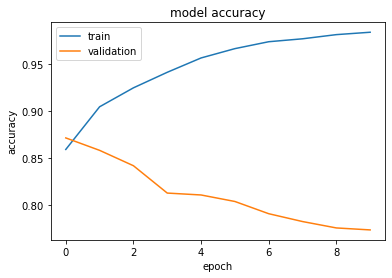

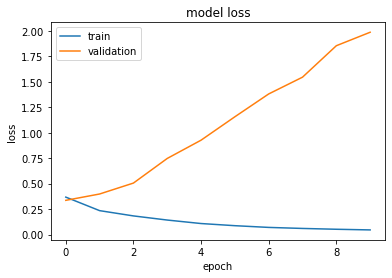

In [76]:
import matplotlib.pyplot as plt
plt.plot(history_3.history['acc'])
plt.plot(history_3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


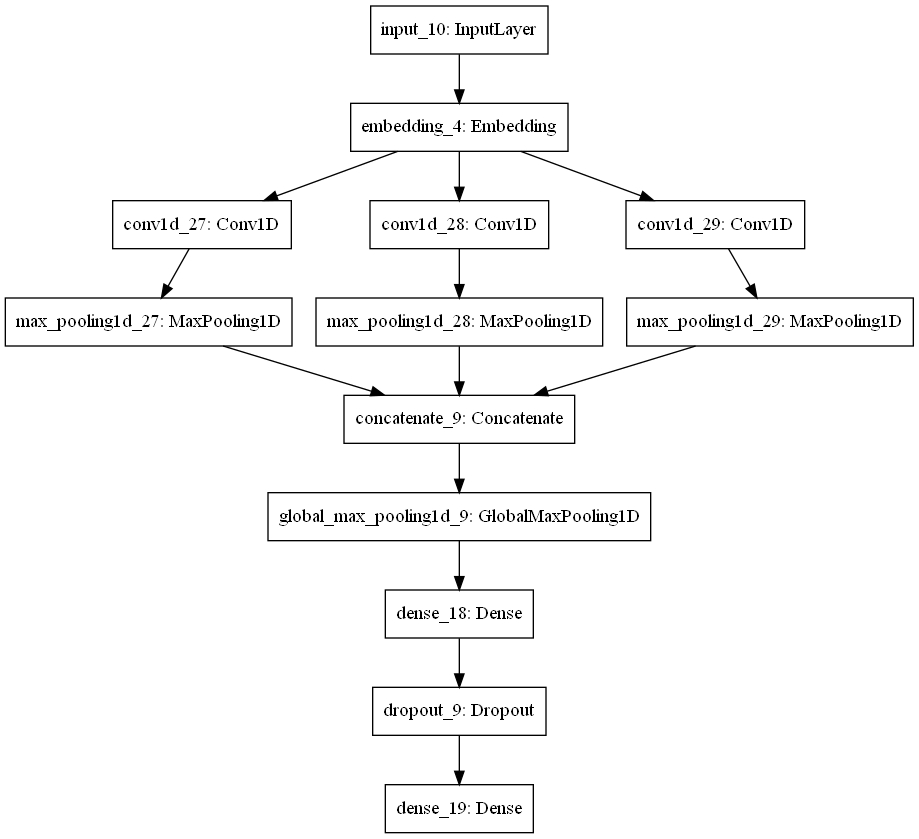

In [78]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np

#model = ResNet50(weights='imagenet')
plot_model(model3, to_file='model.png')

In [180]:
results=model3.predict(x_test_full)
predictions=np.argmax(results,axis=1)


onehot_labels = enc_dev.get_feature_names()

output_labels = list()
for label in onehot_labels:
    output_labels.append(label.replace("x0_",""))

out = list()
for prediction in predictions:
    out.append(output_labels[prediction])

# For output only:
columns_titles = ["id","region"]
prediction=reformat_prediction(out)
tweet_test_Y=prediction.reindex(columns=columns_titles)
tweet_test_Y.id.astype(int)
tweet_test_Y.to_csv('cnn_my_glove200d.csv',index=False,float_format='%.f')

## My own Glove 300d training (not used)

Use the same model as glove200d, but instead average them per tweet level, use embedded layer.

In [70]:
import string
path_to_my_glove_file = os.path.join("G:/UNIMELB/ML/A3/emb/glove.840B.300d.txt")
#G:/UNIMELB/ML/A3/emb/my_glove_vectors_b2.txt
#G:/UNIMELB/ML/A3/emb/my_glove_vectors_b5.txt

# Use my own training set as complement set
embeddings_index = {}
with open(path_to_my_glove_file,'r', encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        word = word.translate(str.maketrans('', '', string.punctuation)).lower() #same way as keras Vectrization.
        coefs = np.fromstring(coefs, sep=" ")
        if embeddings_index.get(word) is None: 
            embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

<ipython-input-70-f9413c76f9b1>:12: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs, sep=" ")


Found 1449265 word vectors.


In [71]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0
x=0
# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    elif embeddings_index.get("#"+word) is not None:
        embedding_matrix[i] = embeddings_index.get("#"+word)
        hits += 1
    elif embeddings_index.get("@"+word) is not None:
        embedding_matrix[i] = embeddings_index.get("@"+word)
        hits += 1
    else:
        misses += 1


print("Converted %d words (%d misses)" % (hits, misses))

Converted 44331 words (98691 misses)


### Model build and evaluation

In [72]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

f1 = layers.Conv1D(128, 2, activation="relu")(embedded_sequences)
f1 = layers.MaxPooling1D(5)(f1)
f2 = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
f2 = layers.MaxPooling1D(5)(f2)
f3 = layers.Conv1D(128, 4, activation="relu")(embedded_sequences)
f3 = layers.MaxPooling1D(5)(f3)
x = layers.concatenate([f1,f2,f3])
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(labels), activation="softmax")(x)
model300d = keras.Model(int_sequences_input, preds)
model300d.summary()

NameError: name 'embedding_layer' is not defined

In [74]:
model300d.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
model300d.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

NameError: name 'model300d' is not defined

In [ ]:
model300d.evaluate(x_dev_full,y_dev,batch_size=300)

In [ ]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

f1 = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
f1 = layers.MaxPooling1D(5)(f1)
f2 = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
f2 = layers.MaxPooling1D(5)(f2)
f3 = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
f3 = layers.MaxPooling1D(5)(f3)
x = layers.concatenate([f1,f2,f3])
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(labels), activation="softmax")(x)
model300d_worse = keras.Model(int_sequences_input, preds)
model300d_worse.summary()

In [ ]:
model300d_worse.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
model300d_worse.fit(x_train, y_train, batch_size=128, epochs=5, validation_data=(x_val, y_val))

In [ ]:
model300d_worse.evaluate(x_dev_full,y_dev,batch_size=300)

# Extra: CHEATING DATA with CNN
For my personal interest only, wont be used in the formal discussion, but here i concatenate both training and dev data as training set. See if this can bring the model to higher acc

In [83]:
# CHEATING DATA
x_cheat = np.concatenate((x_train_full,x_dev_full),axis=0)
y_cheat = np.concatenate((y_train_full,y_dev),axis=0)

## My_glove embedded vector model

In [84]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)

f1 = layers.Conv1D(128, 2, activation="relu")(embedded_sequences)
f1 = layers.MaxPooling1D(5)(f1)
f2 = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
f2 = layers.MaxPooling1D(5)(f2)
f3 = layers.Conv1D(128, 4, activation="relu")(embedded_sequences)
f3 = layers.MaxPooling1D(5)(f3)
x = layers.concatenate([f1,f2,f3])
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(labels), activation="softmax")(x)
model4 = keras.Model(int_sequences_input, preds)
model4.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 200)    28604800    input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, None, 128)    51328       embedding_4[1][0]                
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, None, 128)    76928       embedding_4[1][0]                
___________________________________________________________________________________________

In [88]:
model4.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
model4.fit(x_cheat, y_cheat, batch_size=32, epochs=1, validation_data=(x_val, y_val))

 960/4540 [=====>........................] - ETA: 17:37 - loss: 0.2460 - acc: 0.8990

KeyboardInterrupt: 

In [86]:
model4.evaluate(x_dev_full,y_dev,batch_size=300)

39/39 [==============================] - 5s 131ms/step - loss: 0.7933 - acc: 0.6597


[0.7932902574539185, 0.6596949696540833]

In [87]:
results=model4.predict(x_test_full)
predictions=np.argmax(results,axis=1)


onehot_labels = enc_dev.get_feature_names()

output_labels = list()
for label in onehot_labels:
    output_labels.append(label.replace("x0_",""))

out = list()
for prediction in predictions:
    out.append(output_labels[prediction])

# For output only:
columns_titles = ["id","region"]
prediction=reformat_prediction(out)
tweet_test_Y=prediction.reindex(columns=columns_titles)
tweet_test_Y.id.astype(int)
tweet_test_Y.to_csv('cnn_cheat.csv',index=False,float_format='%.f')

In [ ]:
# CHEATING DATA
x_cheat = np.concatenate((tx,dx),axis=0)
y_cheat = np.concatenate((ty,dy),axis=0)

In [ ]:
from tensorflow.keras import layers

embedded_sequences = keras.Input(shape=(300,1))

f1 = layers.Conv1D(100, 5, activation="relu")(embedded_sequences)
f1 = layers.MaxPooling1D(5)(f1)
f2 = layers.Conv1D(100, 5, activation="relu")(embedded_sequences)
f2 = layers.MaxPooling1D(5)(f2)
f3 = layers.Conv1D(100, 5, activation="relu")(embedded_sequences)
f3 = layers.MaxPooling1D(5)(f3)
x = layers.concatenate([f1,f2,f3])
x = layers.GlobalMaxPooling1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(labels), activation="softmax")(x)
model5 = keras.Model(embedded_sequences, preds)
model5.summary()


In [ ]:
model5.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
model5.fit(x_cheat, y_cheat, batch_size=128, epochs=20, validation_data=(dx, dy))